In [ ]:
%pip install pydub librosa matplotlib numpy

In [ ]:
import os
from pydub import AudioSegment

# 디렉토리 설정
input_dir = './m4a'
output_dir = './wav'

# 출력 디렉토리 생성 (존재하지 않으면)
os.makedirs(output_dir, exist_ok=True)

# m4a 파일 리스트
files = [f for f in os.listdir(input_dir) if f.endswith('.m4a')]

for file in files:
    # 파일 경로 설정
    m4a_path = os.path.join(input_dir, file)
    wav_path = os.path.join(output_dir, file.replace('.m4a', '.wav'))

    # m4a -> wav 변환
    sound = AudioSegment.from_file(m4a_path, format="m4a")
    sound.export(wav_path, format="wav")


In [ ]:
import os
from pydub import AudioSegment

# 입력 디렉토리: 변환된 wav 파일들
input_dir = './wav'
# 출력 디렉토리: 1초 단위로 자른 파일들 저장
output_dir = './slices'
os.makedirs(output_dir, exist_ok=True)

# 파일 리스트 (wav만)
files = [f for f in os.listdir(input_dir) if f.endswith('.wav')]

slice_index = 1  # 저장될 파일 번호

for file in files:
    wav_path = os.path.join(input_dir, file)
    audio = AudioSegment.from_wav(wav_path)

    # 전체 길이를 1초 단위로 자르기 (남는 부분 버림)
    full_seconds = len(audio) // 1000  # 정수 초만큼 자름

    for i in range(full_seconds):
        start = i * 1000
        end = start + 1000
        segment = audio[start:end]

        # 파일명: 1.wav, 2.wav, ...
        output_path = os.path.join(output_dir, f"{slice_index}.wav")
        segment.export(output_path, format="wav")
        slice_index += 1

In [5]:
import numpy as np

# 정규화된 FFT 진폭 → 절대 dB SPL로 변환
def amplitude_to_db_SPL(amplitude, bit_depth=16, mic_sensitivity_dbv_pa=-40):
    max_pcm = 2 ** (bit_depth - 1)  # 16-bit PCM 최대값: 32768
    amplitude_norm = amplitude / max_pcm  # -1.0 ~ 1.0

    mic_sensitivity_v_pa = 10 ** (mic_sensitivity_dbv_pa / 20)  # ex: -40 dBV/Pa → 0.01 V/Pa

    pressure_pa = amplitude_norm / mic_sensitivity_v_pa  # 전압 → 음압(Pa)

    db_spl = 20 * np.log10(np.maximum(pressure_pa, 1e-12) / 20e-6)  # 20 µPa 기준

    return db_spl

# FFT 적용 및 dB SPL 변환 포함한 주파수 분석 함수
def analyze_frequency(signal, sampling_rate):
    fft_signal = np.fft.fft(signal)
    frequencies_fft = np.fft.fftfreq(len(signal), 1/sampling_rate)
    half_len = len(signal) // 2
    fft_signal = fft_signal[:half_len]
    frequencies_fft = frequencies_fft[:half_len]
    
    amplitude = np.abs(fft_signal)
    amplitude = amplitude / len(signal)  # 정규화

    amplitude_db_spl = amplitude_to_db_SPL(amplitude)

    return frequencies_fft, amplitude_db_spl

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import glob
from matplotlib import rcParams

# 한글 폰트 설정
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

# 주파수 스펙트럼 시각화 (50dB 이상만 필터링)
def plot_frequency(frequencies, amplitude_db, title, output_dir='./freq_db'):
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{title.replace(' ', '_')}_spectrum.png")
    
    # 50 dB SPL 이상인 값만 필터링
    indices_above_50db = np.where(amplitude_db >= 50)[0]
    frequencies_filtered = frequencies[indices_above_50db]
    amplitude_db_filtered = amplitude_db[indices_above_50db]
    
    # 데이터가 없으면 빈 그래프를 그리지 않도록 처리
    if len(frequencies_filtered) == 0:
        print(f"{title}에서 50dB 이상인 주파수가 없습니다.")
        return

    #plt.figure(figsize=(10, 6))
    #plt.plot(frequencies_filtered, amplitude_db_filtered)
    #plt.title(title)
    #plt.xlabel("주파수 (Hz)")
    #plt.ylabel("음압 (dB SPL)")
    #plt.grid(True)
    #plt.tight_layout()
    #plt.savefig(output_path)
    #plt.close()

for file in glob.glob(os.path.join("./slices", "*.wav")):
    sampling_rate, signal = wavfile.read(file)

    # 스테레오를 모노로 변환 -> 양쪽 채널(L/R)이 있는 오디오를 하나의 채널로 합치는 것
    if signal.ndim > 1:
        signal = signal.mean(axis=1) # 평균값 사용

    frequencies, amplitude_db = analyze_frequency(signal, sampling_rate)
    plot_frequency(frequencies, amplitude_db, f"{os.path.basename(file)}의 주파수 스펙트럼")


1.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
1019.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
1060.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
1093.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
1095.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
1096.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
1105.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
1111.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
1119.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
1138.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
1144.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
1153.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
2.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
2186.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
2187.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
2470.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
351.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
352.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
354.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
355.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
357.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
358.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
359.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
360.wav의 주파수 스펙트럼에서 50dB 이상인 주파수가 없습니다.
362.wav의 주파수 스펙트럼에서 50dB 이상인 주

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# FrequencyAttention 클래스는 주파수 성분에 대한 주의 메커니즘을 구현
# 주파수 성분을 입력으로 받아서 각 주파수 성분에 대한 가중치를 계산
class FrequencyAttention(nn.Module):
    def __init__(self, freq_bins):
        super(FrequencyAttention, self).__init__()
        self.conv1 = nn.Conv1d(1, 1, kernel_size=3, padding=1)  # (1, 128) → (1, 128)
        self.fc = nn.Linear(freq_bins, freq_bins)

    def forward(self, x):
        # x: (batch=1, freq_bins, time_frames)
        x = x.unsqueeze(0)  # (1, freq_bins, time_frames)
        x = x.unsqueeze(1)  # (1, 1, freq_bins, time_frames)
        x = F.avg_pool2d(x, (1, x.shape[-1]))  # (1, 1, freq_bins, 1)
        x = x.squeeze(-1)  # (1, 1, freq_bins)
        x = self.conv1(x)  # (1, 1, freq_bins)
        x = F.relu(x)
        x = x.squeeze(1)  # (1, freq_bins)
        x = self.fc(x)  # (1, freq_bins)
        weights = F.softmax(x, dim=1)  # Softmax → 주파수별 가중치
        return weights  # shape: (1, freq_bins)

def apply_frequency_attention(spec, model):
    spec_tensor = torch.tensor(spec, dtype=torch.float32)
    weights = model(spec_tensor)  # shape: (1, freq_bins)
    weights_expanded = weights.T @ torch.ones((1, spec.shape[1]))  # outer product로 확장
    weighted_spec = spec_tensor * weights_expanded  # 주파수별 가중치 곱
    return weighted_spec.detach().numpy(), weights.detach().numpy().squeeze()


In [2]:
import librosa

def generate_mel_spectrogram(file_path, sr=22050, n_fft=2048, hop_length=512, n_mels=224):
    # 오디오 로드
    y, sr = librosa.load(file_path, sr=sr, mono=True)

    # Mel 스펙트로그램 생성
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                       hop_length=hop_length, n_mels=n_mels)

    # Mel 주파수 축 생성
    mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=librosa.note_to_hz('C1'))

    return S, mel_frequencies, sr

In [ ]:
import os
import numpy as np
import librosa
import csv
import glob
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import rcParams

plot_dir = './scatter'
csv_filename = 'frequency_clusters_50dB.csv'
header = ['파일명', '클러스터', '구간-시작(초)', '구간-종료(초)', '최소 주파수(Hz)', '최대 주파수(Hz)', '최빈값(Hz)', '최대 진폭(dB SPL)']
os.makedirs(plot_dir, exist_ok=True)  # plots 디렉토리 생성

# 한글 폰트 설정
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)

    # 각 파일에 대해 주요 주파수를 확인하고 클러스터링
    for file_path in glob.glob(os.path.join('./slices', '*.wav')):
        # Mel 스펙트로그램 생성
        mel_spec, mel_freqs, sr = generate_mel_spectrogram(file_path)

        # 진폭을 dB SPL로 변환
        mel_spec_db_spl = amplitude_to_db_SPL(mel_spec)

        threshold_amp = 50
        important_points = []

        # 50 dB 이상인 부분만 추출
        for freq_bin in range(mel_spec_db_spl.shape[0]):  
            for t in range(mel_spec_db_spl.shape[1]):
                if mel_spec_db_spl[freq_bin, t] >= threshold_amp:
                    time_sec = librosa.frames_to_time(t, sr=sr)
                    freq_hz = mel_freqs[freq_bin]
                    amplitude_db = mel_spec_db_spl[freq_bin, t]
                    important_points.append([file_path, time_sec, freq_hz, amplitude_db])

        if len(important_points) == 0:
            print(f"{os.path.basename(file_path)}: 50 dB 이상인 중요한 지점이 없습니다.")
            continue

        # DBSCAN으로 군집화
        X = np.array(important_points)[:, 2:3].astype(float)
        clustering = DBSCAN(eps=3, min_samples=5).fit(X)

        # 클러스터 정보 출력
        clusters = {}
        for label, point in zip(clustering.labels_, important_points):
            if label == -1:
                continue
            clusters.setdefault(label, []).append(point)
        
        # 유효한 군집이 하나도 없으면 무시하고 넘어감
        if len(clusters) == 0:
            print(f"{os.path.basename(file_path)}: 유효한 클러스터가 없어 생략합니다.")
            continue

        # 산점도 그리기 (유효한 군집이 있을 경우에만)
        #time = [point[1] for point in important_points]
        #freq = [point[2] for point in important_points]

        #plt.figure(figsize=(10, 6))
        #plt.scatter(time, freq, c='blue', alpha=0.6)
        #plt.title('주파수와 시간에 따른 데이터 분포')
        #plt.xlabel('시간 (초)')
        #plt.ylabel('주파수 (Hz)')
        #plt.grid(True)

        # 파일 저장
        #plot_filename = os.path.splitext(os.path.basename(file_path))[0] + '_scatter.png'
        #plot_path = os.path.join(plot_dir, plot_filename)
        #plt.savefig(plot_path)
        #plt.close()

        # 겹치지 않는 구간 정렬 및 병합
        merged_clusters = []
        for cluster_id, points in clusters.items():
            times = [p[1] for p in points]
            freqs = [p[2] for p in points]
            amplitudes = [p[3] for p in points]

            mode_freqs = stats.mode(freqs, keepdims=True)[0]
            mode_freq = mode_freqs[0] if isinstance(mode_freqs, np.ndarray) else mode_freqs

            min_time = min(times)
            max_time = max(times)
            min_freq = min(freqs)
            max_freq = max(freqs)
            max_amplitude = max(amplitudes)

            merged_clusters.append((min_time, max_time, cluster_id, min_freq, max_freq, mode_freq, max_amplitude))

        # 시간 기준으로 오름차순 정렬
        merged_clusters.sort(key=lambda x: x[0])

        # 겹치지 않도록 필터링
        non_overlapping_clusters = []
        last_end = -1
        for cluster in merged_clusters:
            start, end = cluster[0], cluster[1]
            if start > last_end:
                non_overlapping_clusters.append(cluster)
                last_end = end

        for cluster in non_overlapping_clusters:
            min_time, max_time, cluster_id, min_freq, max_freq, mode_freq, max_amplitude = cluster
            writer.writerow([
                os.path.basename(file_path),
                cluster_id,
                f"{min_time:.2f}",
                f"{max_time:.2f}",
                f"{min_freq:.2f}",
                f"{max_freq:.2f}",
                f"{mode_freq:.2f}",
                f"{max_amplitude:.2f}"
            ])

            print(
                f"[{os.path.basename(file_path)}] "
                f"클러스터 {cluster_id} | "
                f"구간: {min_time:.2f}s ~ {max_time:.2f}s | "
                f"최빈 주파수: {mode_freq:.2f} Hz | "
                f"최대 진폭: {max_amplitude:.2f} dB SPL"
            )


1.wav: 50 dB 이상인 중요한 지점이 없습니다.
10.wav: 50 dB 이상인 중요한 지점이 없습니다.
100.wav: 50 dB 이상인 중요한 지점이 없습니다.
1000.wav: 유효한 클러스터가 없어 생략합니다.
1001.wav: 유효한 클러스터가 없어 생략합니다.
1002.wav: 50 dB 이상인 중요한 지점이 없습니다.
1003.wav: 50 dB 이상인 중요한 지점이 없습니다.
1004.wav: 50 dB 이상인 중요한 지점이 없습니다.
1005.wav: 50 dB 이상인 중요한 지점이 없습니다.
1006.wav: 50 dB 이상인 중요한 지점이 없습니다.
1007.wav: 50 dB 이상인 중요한 지점이 없습니다.
[1008.wav] 클러스터 0 | 구간: 0.35s ~ 0.49s | 최빈 주파수: 224.77 Hz | 최대 진폭: 61.01 dB SPL
1009.wav: 유효한 클러스터가 없어 생략합니다.
101.wav: 50 dB 이상인 중요한 지점이 없습니다.
1010.wav: 유효한 클러스터가 없어 생략합니다.
1011.wav: 50 dB 이상인 중요한 지점이 없습니다.
1012.wav: 50 dB 이상인 중요한 지점이 없습니다.
1013.wav: 유효한 클러스터가 없어 생략합니다.
1014.wav: 50 dB 이상인 중요한 지점이 없습니다.
1015.wav: 유효한 클러스터가 없어 생략합니다.
[1016.wav] 클러스터 12 | 구간: 0.49s ~ 0.70s | 최빈 주파수: 402.06 Hz | 최대 진폭: 67.47 dB SPL
1017.wav: 50 dB 이상인 중요한 지점이 없습니다.
1018.wav: 50 dB 이상인 중요한 지점이 없습니다.
1019.wav: 50 dB 이상인 중요한 지점이 없습니다.
102.wav: 50 dB 이상인 중요한 지점이 없습니다.
1020.wav: 50 dB 이상인 중요한 지점이 없습니다.
1021.wav: 50 dB 이상인 중요한 지점이 없습니다.
1022.wav: 50 dB 이상인 중

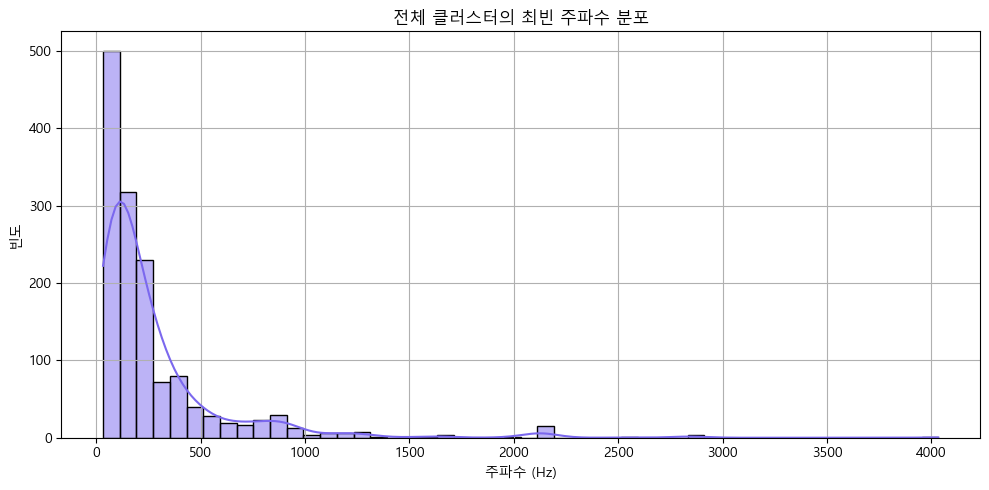

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import csv

all_freqs = []

# CSV 파일에서 모든 최빈값 주파수 수집
with open('frequency_clusters_50dB.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # 헤더 스킵

    for row in reader:
        try:
            mode_freq = float(row[6])  # 최빈값(Hz)
            all_freqs.append(mode_freq)
        except ValueError:
            continue  # 혹시나 데이터 오류가 있을 경우 건너뜀

# 시각화: 히스토그램 + KDE(곡선) 커널 밀도 추정
plt.figure(figsize=(10, 5))
sns.histplot(all_freqs, bins=50, kde=True, color='mediumslateblue', edgecolor='black')

plt.title('전체 클러스터의 최빈 주파수 분포')
plt.xlabel('주파수 (Hz)')
plt.ylabel('빈도')
plt.grid(True)
plt.tight_layout()
plt.show()

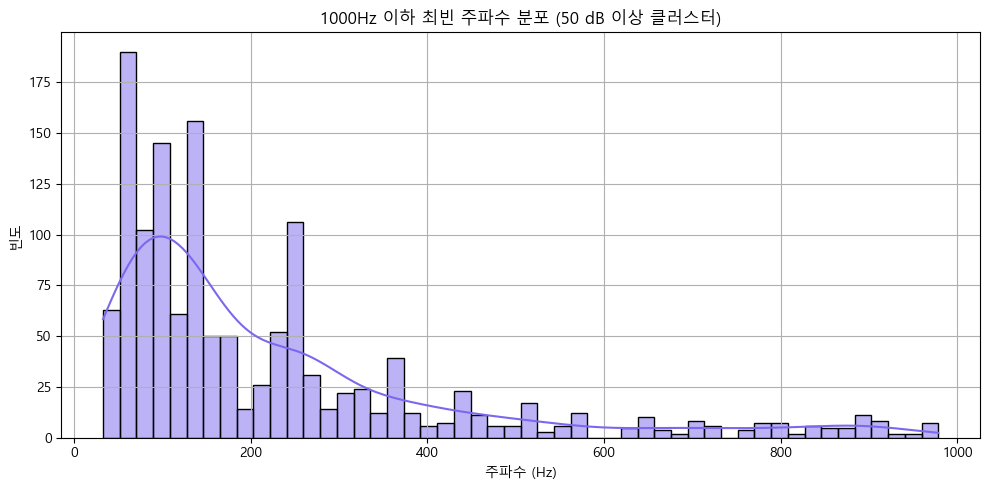

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import csv

all_freqs = []

# CSV 파일에서 모든 최빈값 주파수 수집
with open('frequency_clusters_50dB.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # 헤더 스킵

    for row in reader:
        try:
            mode_freq = float(row[6])  # 최빈값(Hz)
            if mode_freq <= 1000:  # 1000Hz 이하만 포함
                all_freqs.append(mode_freq)
        except ValueError:
            continue  # 데이터 오류 건너뜀

# 시각화: 히스토그램 + KDE(곡선) 커널 밀도 추정
plt.figure(figsize=(10, 5))
sns.histplot(all_freqs, bins=50, kde=True, color='mediumslateblue', edgecolor='black')

plt.title('1000Hz 이하 최빈 주파수 분포 (50 dB 이상 클러스터)')
plt.xlabel('주파수 (Hz)')
plt.ylabel('빈도')
plt.grid(True)
plt.tight_layout()
plt.show()